# Data Pre-Processing

In [ ]:
!pip install -q pillow matplotlib pandas tqdm pycocotools

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q diffusers transformers accelerate safetensors
!pip install -q ftfy regex pillow matplotlib numpy pandas
!pip install -q xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 5.0 MB/s eta 0:00:00


In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from pycocotools.coco import COCO
import urllib.request
import torch
from pathlib import Path
from transformers import CLIPTextModel, CLIPTokenizer, CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from diffusers import DDPMScheduler, UNet2DConditionModel, AutoencoderKL

import transformers
import diffusers

# random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [3]:
class Config:
    NUM_SAMPLES = 10000
    MIN_IMAGE_SIZE = 256
    TARGET_IMAGE_SIZE = 512
    MIN_CAPTION_LENGTH = 5
    MAX_CAPTION_LENGTH = 100

    OUTPUT_DIR = "/content/drive/MyDrive/text2image_project"
    PROCESSED_DATA_DIR = os.path.join(OUTPUT_DIR, "processed_data")
    IMAGES_DIR = os.path.join(PROCESSED_DATA_DIR, "images")
    METADATA_FILE = os.path.join(PROCESSED_DATA_DIR, "metadata.json")
    CAPTIONS_FILE = os.path.join(PROCESSED_DATA_DIR, "captions.csv")
    STATS_FILE = os.path.join(PROCESSED_DATA_DIR, "statistics.json")

config = Config()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Create directories
os.makedirs(config.PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(config.IMAGES_DIR, exist_ok=True)

print(f"Directories created at: {config.PROCESSED_DATA_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories created at: /content/drive/MyDrive/text2image_project/processed_data


In [4]:
!mkdir -p /content/coco_data
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/coco_data/annotations.zip
!cd /content/coco_data && unzip -q annotations.zip

annotation_file = '/content/coco_data/annotations/captions_train2017.json'
coco = COCO(annotation_file)

# Get image IDs
img_ids = coco.getImgIds()
random.shuffle(img_ids)

print(f"Loaded {len(img_ids)} image IDs")

replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: loading annotations into memory...
Done (t=3.53s)
creating index...
index created!
Loaded 118287 image IDs


In [5]:
def clean_caption(caption):
    caption = ' '.join(caption.split()).strip()
    if caption:
        caption = caption[0].upper() + caption[1:]
    if caption and caption[-1] not in '.!?':
        caption += '.'
    return caption

def is_valid_caption(caption):
    if not caption or not isinstance(caption, str):
        return False
    word_count = len(caption.split())
    return config.MIN_CAPTION_LENGTH <= word_count <= config.MAX_CAPTION_LENGTH

def resize_image(image, target_size=512):
    width, height = image.size
    scale = target_size / min(width, height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    image = image.resize((new_width, new_height), Image.LANCZOS)

    left = (new_width - target_size) // 2
    top = (new_height - target_size) // 2
    right = left + target_size
    bottom = top + target_size

    return image.crop((left, top, right, bottom))

def download_image(url, timeout=10):
    """Download image from URL"""
    try:
        req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req, timeout=timeout) as response:
            image = Image.open(response).convert('RGB')
            return image
    except:
        return None


In [6]:
processed_samples = []
skipped = {'invalid_image': 0, 'invalid_caption': 0, 'download_failed': 0}

pbar = tqdm(total=config.NUM_SAMPLES, desc="Processing")

for img_id in img_ids:
    if len(processed_samples) >= config.NUM_SAMPLES:
        break

    try:
        # Get image info
        img_info = coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']

        # Download image
        image = download_image(img_url)
        if image is None:
            skipped['download_failed'] += 1
            continue

        # Check image size
        if min(image.size) < config.MIN_IMAGE_SIZE:
            skipped['invalid_image'] += 1
            continue

        # Get captions
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            if len(processed_samples) >= config.NUM_SAMPLES:
                break

            caption = ann['caption']

            if not is_valid_caption(caption):
                skipped['invalid_caption'] += 1
                continue

            cleaned_caption = clean_caption(caption)
            processed_image = resize_image(image, config.TARGET_IMAGE_SIZE)

            # Save
            image_id = f"coco_{len(processed_samples):06d}"
            image_filename = f"{image_id}.jpg"
            image_path = os.path.join(config.IMAGES_DIR, image_filename)
            processed_image.save(image_path, quality=95)

            processed_samples.append({
                'image_id': image_id,
                'image_filename': image_filename,
                'image_path': image_path,
                'caption': cleaned_caption,
                'original_caption': caption,
                'word_count': len(cleaned_caption.split()),
                'image_size': processed_image.size,
                'original_coco_id': img_id,
                'coco_url': img_url
            })

            pbar.update(1)

    except Exception as e:
        skipped['download_failed'] += 1
        continue

pbar.close()

print(f"\nProcessing complete!")
print(f"   Processed: {len(processed_samples)}")
print(f"   Skipped - Invalid images: {skipped['invalid_image']}")
print(f"   Skipped - Invalid captions: {skipped['invalid_caption']}")
print(f"   Skipped - Download failed: {skipped['download_failed']}")



Processing:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing complete!
   Processed: 10000
   Skipped - Invalid images: 17
   Skipped - Invalid captions: 0
   Skipped - Download failed: 0


In [7]:
with open(config.METADATA_FILE, 'w') as f:
    json.dump(processed_samples, f, indent=2)

df = pd.DataFrame(processed_samples)
df.to_csv(config.CAPTIONS_FILE, index=False)

print(f"\nData saved!")


Data saved!


In [8]:
word_counts = [s['word_count'] for s in processed_samples]

statistics = {
    'total_samples': len(processed_samples),
    'caption_stats': {
        'mean_word_count': float(np.mean(word_counts)),
        'median_word_count': float(np.median(word_counts)),
        'min_word_count': int(np.min(word_counts)),
        'max_word_count': int(np.max(word_counts)),
        'std_word_count': float(np.std(word_counts))
    },
    'image_stats': {
        'image_size': f"{config.TARGET_IMAGE_SIZE}x{config.TARGET_IMAGE_SIZE}",
        'total_images': len(processed_samples)
    },
    'skipped_samples': skipped
}

with open(config.STATS_FILE, 'w') as f:
    json.dump(statistics, f, indent=2)

print("\nDataset Statistics:")
print(f"  Mean word count: {statistics['caption_stats']['mean_word_count']:.2f}")
print(f"  Median word count: {statistics['caption_stats']['median_word_count']:.1f}")
print(f"  Range: {statistics['caption_stats']['min_word_count']}-{statistics['caption_stats']['max_word_count']}")




Dataset Statistics:
  Mean word count: 10.45
  Median word count: 10.0
  Range: 7-44


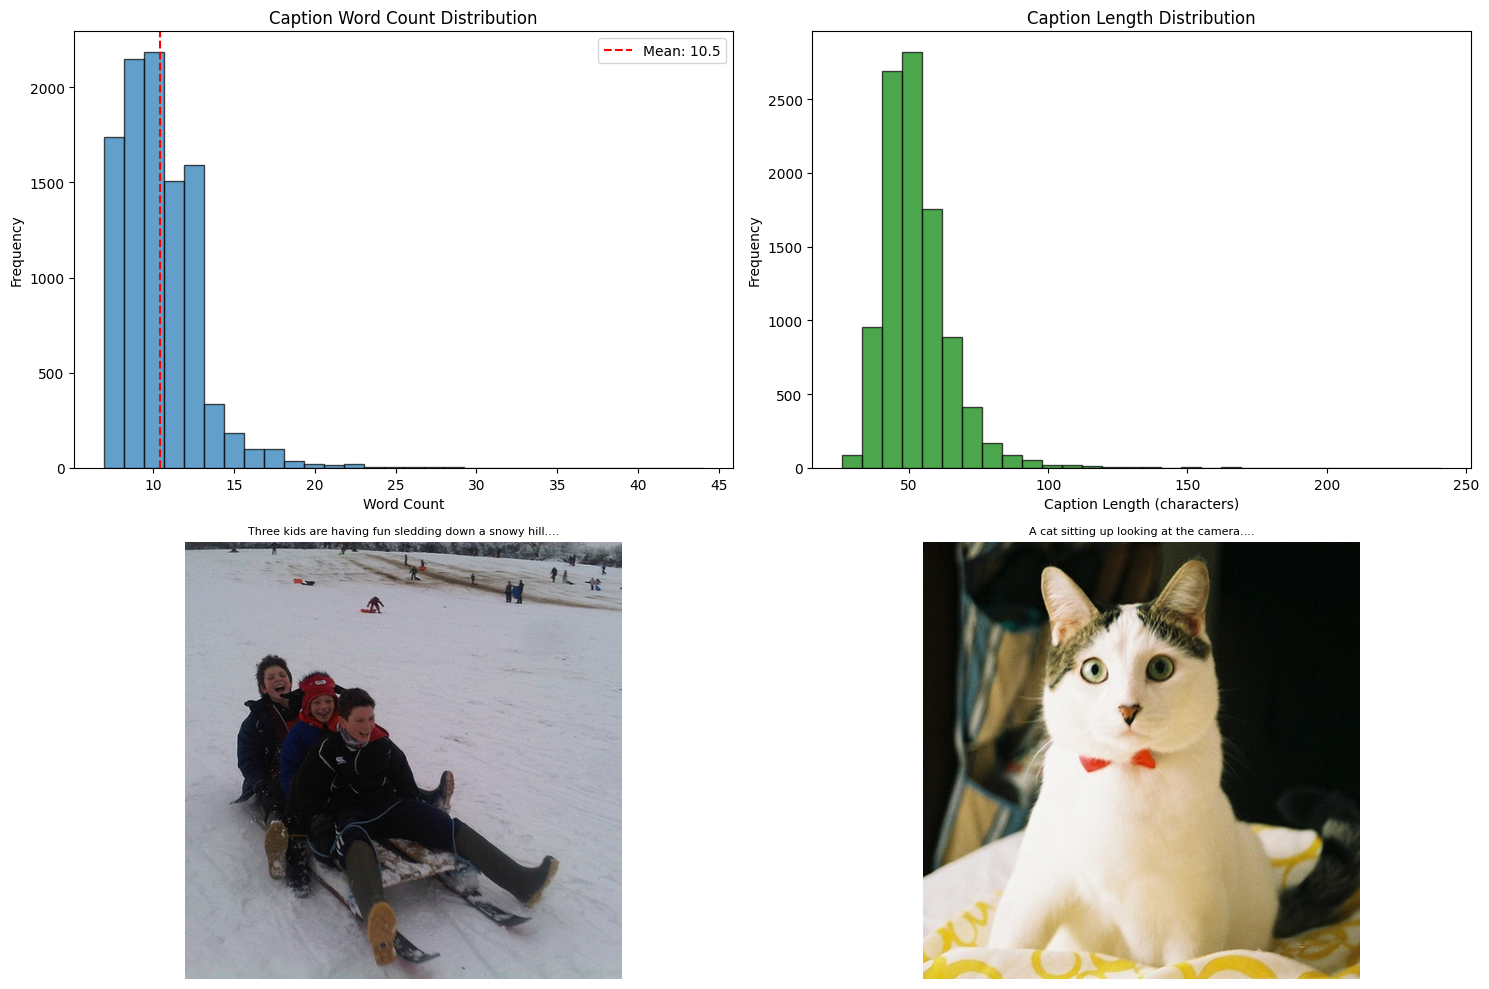

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Word count distribution
axes[0, 0].hist(word_counts, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Caption Word Count Distribution')
axes[0, 0].axvline(np.mean(word_counts), color='red', linestyle='--',
                    label=f'Mean: {np.mean(word_counts):.1f}')
axes[0, 0].legend()

# Caption length
caption_lengths = [len(s['caption']) for s in processed_samples]
axes[0, 1].hist(caption_lengths, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Caption Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Caption Length Distribution')

# Sample images
sample_indices = random.sample(range(len(processed_samples)), 2)
for idx, sample_idx in enumerate(sample_indices):
    sample = processed_samples[sample_idx]
    img = Image.open(sample['image_path'])

    ax = axes[1, idx]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{sample['caption'][:60]}...", fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(config.PROCESSED_DATA_DIR, 'statistics_overview.png'), dpi=150)
plt.show()

# Baseline

In [5]:
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Memory: 15.83 GB


In [19]:
class ClipConfig:
  CLIP_MODEL = "openai/clip-vit-base-patch32"
  SD_MODEL = "runwayml/stable-diffusion-v1-5"

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

  NUM_INFERENCE_STEPS = 50
  GUIDANCE_SCALE = 7.5
  IMAGE_SIZE = 512

  OUTPUT_DIR = "/content/drive/MyDrive/text2image_project"
  BASELINE_DIR = os.path.join(OUTPUT_DIR, "baseline_results")
  EMBEDDINGS_DIR = os.path.join(BASELINE_DIR, "embeddings")
  GENERATED_IMAGES_DIR = os.path.join(BASELINE_DIR, "generated_images")

  TEST_PROMPTS = [
      "a photo of a cat sitting on a window sill",
      "a beautiful sunset over the ocean with sailboats",
      "a robot playing chess in a futuristic city",
      "a bowl of fresh fruit on a wooden table",
      "an astronaut riding a horse on the moon"
  ]

config = ClipConfig()



In [7]:
os.makedirs(config.BASELINE_DIR, exist_ok=True)
os.makedirs(config.EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(config.GENERATED_IMAGES_DIR, exist_ok=True)

In [20]:
print(f"Loading CLIP model: {config.CLIP_MODEL}")
clip_tokenizer = CLIPTokenizer.from_pretrained(
        config.CLIP_MODEL,
        token=False
    )

clip_text_encoder = CLIPTextModel.from_pretrained(
        config.CLIP_MODEL,
        token=False
    )

clip_text_encoder = clip_text_encoder.to(config.DEVICE)
clip_text_encoder.eval()

print(f"CLIP model loaded on {config.DEVICE}")
print(f"Model parameters: {sum(p.numel() for p in clip_text_encoder.parameters()) / 1e6:.2f}M")
print(f"Embedding dimension: {clip_text_encoder.config.hidden_size}")


Loading CLIP model: openai/clip-vit-base-patch32
CLIP model loaded on cuda
Model parameters: 63.17M
Embedding dimension: 512


In [21]:
class TextEmbeddingPipeline:
    def __init__(self, tokenizer, text_encoder, device):
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.device = device

    def encode_text(self, text, max_length=77):
        # Tokenize text
        text_inputs = self.tokenizer(
            text,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt"
        )

        # Move to device
        text_input_ids = text_inputs.input_ids.to(self.device)

        # Get embeddings
        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input_ids)[0]

        return text_embeddings

    def encode_batch(self, text_list):

        return self.encode_text(text_list)

    def get_embedding_stats(self, embeddings):

        stats = {
            'shape': list(embeddings.shape),
            'mean': float(embeddings.mean()),
            'std': float(embeddings.std()),
            'min': float(embeddings.min()),
            'max': float(embeddings.max()),
            'norm': float(torch.norm(embeddings))
        }
        return stats

# Initialize pipeline
text_pipeline = TextEmbeddingPipeline(
    tokenizer=clip_tokenizer,
    text_encoder=clip_text_encoder,
    device=config.DEVICE
)

print("Text-to-Embedding pipeline initialized")


Text-to-Embedding pipeline initialized


In [22]:
# Test with sample prompts
test_results = []

for idx, prompt in enumerate(config.TEST_PROMPTS):
    print(f"\n[{idx+1}/{len(config.TEST_PROMPTS)}] Processing: '{prompt}'")

    # Generate embedding
    embedding = text_pipeline.encode_text(prompt)

    # Get statistics
    stats = text_pipeline.get_embedding_stats(embedding)

    # Save embedding
    embedding_path = os.path.join(
        config.EMBEDDINGS_DIR,
        f"embedding_{idx:02d}.pt"
    )
    torch.save(embedding, embedding_path)

    # Store results
    result = {
        'prompt': prompt,
        'embedding_path': embedding_path,
        'embedding_stats': stats
    }
    test_results.append(result)

    print(f"Shape: {stats['shape']}")
    print(f"Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
    print(f"Saved to: {embedding_path}")

print("\nAll embeddings generated and saved!")

# Save test results
results_file = os.path.join(config.BASELINE_DIR, "embedding_test_results.json")
with open(results_file, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"Results saved to: {results_file}")



[1/5] Processing: 'a photo of a cat sitting on a window sill'
Shape: [1, 77, 512]
Mean: 0.1219, Std: 1.0594
Saved to: /content/drive/MyDrive/text2image_project/baseline_results/embeddings/embedding_00.pt

[2/5] Processing: 'a beautiful sunset over the ocean with sailboats'
Shape: [1, 77, 512]
Mean: 0.1177, Std: 1.0136
Saved to: /content/drive/MyDrive/text2image_project/baseline_results/embeddings/embedding_01.pt

[3/5] Processing: 'a robot playing chess in a futuristic city'
Shape: [1, 77, 512]
Mean: 0.1210, Std: 1.0502
Saved to: /content/drive/MyDrive/text2image_project/baseline_results/embeddings/embedding_02.pt

[4/5] Processing: 'a bowl of fresh fruit on a wooden table'
Shape: [1, 77, 512]
Mean: 0.1138, Std: 1.0448
Saved to: /content/drive/MyDrive/text2image_project/baseline_results/embeddings/embedding_03.pt

[5/5] Processing: 'an astronaut riding a horse on the moon'
Shape: [1, 77, 512]
Mean: 0.1202, Std: 1.0639
Saved to: /content/drive/MyDrive/text2image_project/baseline_result

In [23]:
from huggingface_hub import login
login()

In [24]:
# Load pre-trained Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained(
    config.SD_MODEL,
    torch_dtype=torch.float16 if config.DEVICE == "cuda" else torch.float32,
    safety_checker=None,  # Disable for educational purposes
    requires_safety_checker=False
)

# Use memory-efficient attention
pipe.enable_attention_slicing()

# Move to device
pipe = pipe.to(config.DEVICE)

print("Stable Diffusion pipeline loaded")
print(f"U-Net parameters: {sum(p.numel() for p in pipe.unet.parameters()) / 1e6:.2f}M")
print(f"VAE parameters: {sum(p.numel() for p in pipe.vae.parameters()) / 1e6:.2f}M")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Stable Diffusion pipeline loaded
U-Net parameters: 859.52M
VAE parameters: 83.65M


In [25]:
# Set seed for reproducibility
generator = torch.Generator(device=config.DEVICE).manual_seed(42)

generated_results = []

for idx, prompt in enumerate(config.TEST_PROMPTS):
    print(f"\n[{idx+1}/{len(config.TEST_PROMPTS)}] Generating image for:")
    print(f"   '{prompt}'")

    # Generate image
    with torch.autocast(config.DEVICE):
        output = pipe(
            prompt=prompt,
            num_inference_steps=config.NUM_INFERENCE_STEPS,
            guidance_scale=config.GUIDANCE_SCALE,
            generator=generator,
            height=config.IMAGE_SIZE,
            width=config.IMAGE_SIZE
        )

    image = output.images[0]

    # Save image
    image_filename = f"baseline_{idx:02d}.png"
    image_path = os.path.join(config.GENERATED_IMAGES_DIR, image_filename)
    image.save(image_path)

    # Store results
    generated_results.append({
        'prompt': prompt,
        'image_path': image_path,
        'image_filename': image_filename,
        'inference_steps': config.NUM_INFERENCE_STEPS,
        'guidance_scale': config.GUIDANCE_SCALE
    })

    print(f"Saved to: {image_path}")

print("\nAll baseline images generated!")

# Save generation results
gen_results_file = os.path.join(config.BASELINE_DIR, "generation_results.json")
with open(gen_results_file, 'w') as f:
    json.dump(generated_results, f, indent=2)



[1/5] Generating image for:
   'a photo of a cat sitting on a window sill'


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/text2image_project/baseline_results/generated_images/baseline_00.png

[2/5] Generating image for:
   'a beautiful sunset over the ocean with sailboats'


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/text2image_project/baseline_results/generated_images/baseline_01.png

[3/5] Generating image for:
   'a robot playing chess in a futuristic city'


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/text2image_project/baseline_results/generated_images/baseline_02.png

[4/5] Generating image for:
   'a bowl of fresh fruit on a wooden table'


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/text2image_project/baseline_results/generated_images/baseline_03.png

[5/5] Generating image for:
   'an astronaut riding a horse on the moon'


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: /content/drive/MyDrive/text2image_project/baseline_results/generated_images/baseline_04.png

All baseline images generated!


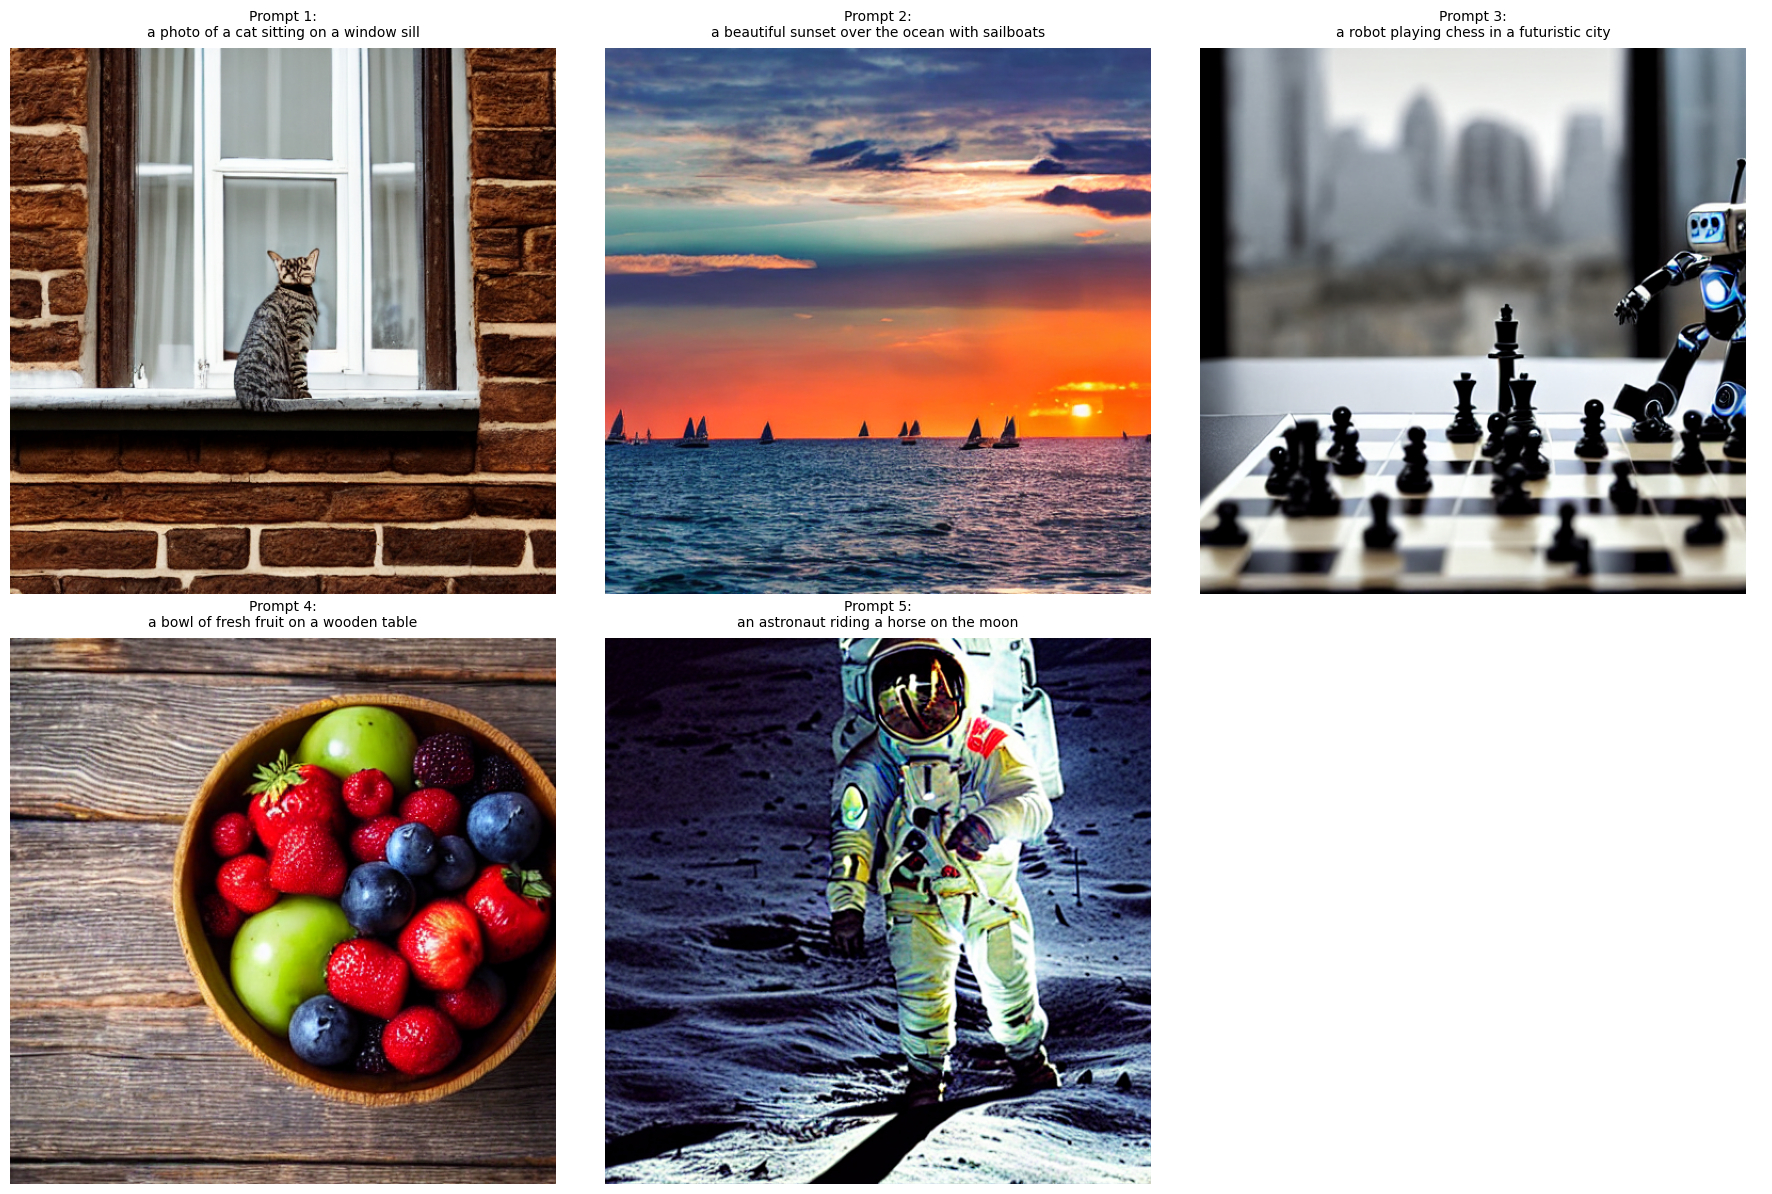

Gallery saved!


In [26]:
# Create visualization of all generated images
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, result in enumerate(generated_results):
    img = Image.open(result['image_path'])

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(
        f"Prompt {idx+1}:\n{result['prompt']}",
        fontsize=10,
        wrap=True,
        pad=10
    )

# Hide the last subplot if we have fewer than 6 images
if len(generated_results) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig(
    os.path.join(config.BASELINE_DIR, 'baseline_generation_gallery.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()

print("Gallery saved!")


Cosine Similarity Matrix between prompts:
(Values closer to 1 indicate more similar prompts)



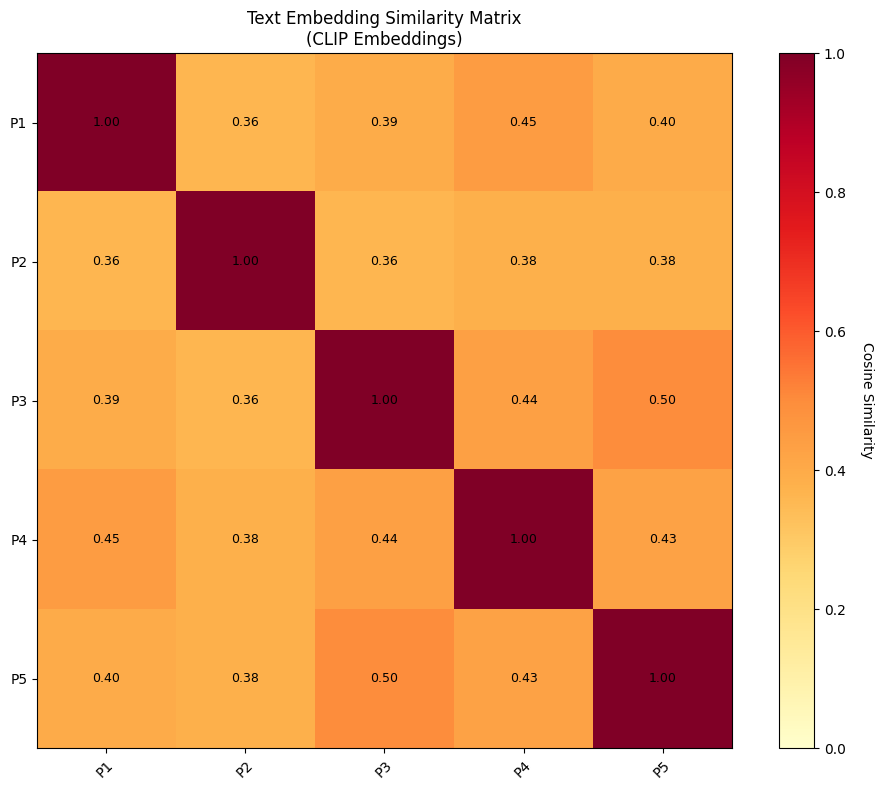


Prompt Labels:
P1: a photo of a cat sitting on a window sill
P2: a beautiful sunset over the ocean with sailboats
P3: a robot playing chess in a futuristic city
P4: a bowl of fresh fruit on a wooden table
P5: an astronaut riding a horse on the moon

Embedding analysis complete!


In [27]:
# Load all embeddings
embeddings_list = []
for result in test_results:
    emb = torch.load(result['embedding_path'])
    embeddings_list.append(emb.cpu())

# Stack embeddings
embeddings_tensor = torch.stack([e.squeeze(0) for e in embeddings_list])

# Compute similarity matrix between prompts
from torch.nn.functional import cosine_similarity

print("\nCosine Similarity Matrix between prompts:")
print("(Values closer to 1 indicate more similar prompts)\n")

similarity_matrix = np.zeros((len(config.TEST_PROMPTS), len(config.TEST_PROMPTS)))

for i in range(len(config.TEST_PROMPTS)):
    for j in range(len(config.TEST_PROMPTS)):
        # Compute cosine similarity between mean embeddings
        emb_i = embeddings_tensor[i].mean(dim=0)
        emb_j = embeddings_tensor[j].mean(dim=0)
        sim = cosine_similarity(emb_i.unsqueeze(0), emb_j.unsqueeze(0))
        similarity_matrix[i, j] = sim.item()

# Visualize similarity matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(similarity_matrix, cmap='YlOrRd', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(config.TEST_PROMPTS)))
ax.set_yticks(np.arange(len(config.TEST_PROMPTS)))
ax.set_xticklabels([f"P{i+1}" for i in range(len(config.TEST_PROMPTS))])
ax.set_yticklabels([f"P{i+1}" for i in range(len(config.TEST_PROMPTS))])

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(config.TEST_PROMPTS)):
    for j in range(len(config.TEST_PROMPTS)):
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title("Text Embedding Similarity Matrix\n(CLIP Embeddings)")
plt.tight_layout()
plt.savefig(
    os.path.join(config.BASELINE_DIR, 'embedding_similarity_matrix.png'),
    dpi=150,
    bbox_inches='tight'
)
plt.show()

# Print similarity matrix
print("\nPrompt Labels:")
for i, prompt in enumerate(config.TEST_PROMPTS):
    print(f"P{i+1}: {prompt}")

print("\nEmbedding analysis complete!")
